In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import itertools
import statsmodels.api as sm
import os
from joblib import Parallel, delayed
import properscoring as ps
from scipy.stats import norm
import properscoring as ps
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.integrate import simps
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

In [16]:
from epiweeks import Week, Year
from datetime import date
def create_epiweek(date):
    return Week.fromdate(date)
def create_epiweekplot(epiweek):
    epiweek = str(epiweek)
    return F'Y{epiweek[:4]}W{epiweek[4:]}'
def filename_to_epiweek(filename):
    return Week.fromstring(F'{filename[:4]}W{filename[4:6]}')
def create_epiweek_fromstr(str):
    return Week.fromstring(str)
def create_epiweek_fromint(int):
    return Week.fromstring(str(int))

### Pooling

In [3]:
def empirical_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(data) + 1) / len(data)
    return sorted_data, cdf

In [4]:
# def linear_pool(weights, y_pred_epiweek_all_models, models):
#     np.random.seed(0)
#     weights /= np.sum(weights)
    
#     for key in y_pred_epiweek_all_models.keys():
#         y_pred_epiweek_all_models[key] = y_pred_epiweek_all_models[key].to_frame().T

#     samples_prob = np.random.choice(models, size=1000, p=weights) # n_samples = 1000, n_submodels = 4

#     combined_samples = np.zeros(1000)
#     for i in range(1000):
#         density_submodel = y_pred_epiweek_all_models[samples_prob[i]].iloc[0,1:].values
#         combined_samples[i] = np.random.choice(density_submodel)

    
#     percentiles = [2.5, 97.5]   # for 95 CI and visualization 
#     bound = np.percentile(combined_samples, percentiles)
    
#     y_val_value = y_pred_epiweek_all_models[models[0]].iloc[0,0]
#     y_val_index = y_pred_epiweek_all_models[models[0]].index   # becasue the epiweek is same for all submodels. so we just choose models[0]
    
#     return combined_samples, y_val_value, y_val_index, bound

In [5]:
def linear_pool(weights, y_pred_epiweek_all_models, models):
    np.random.seed(0)
    weights /= np.sum(weights)
    
    cdf_list = []
    x_min = float('inf')
    x_max = float('-inf')
    for key in models:
        y_pred_epiweek_all_models[key] = y_pred_epiweek_all_models[key].to_frame().T
        x, cdf = empirical_cdf(y_pred_epiweek_all_models[key].iloc[0,1:].values)
        cdf_list.append((x, cdf))
        x_min = min(x_min, x.min())
        x_max = max(x_max, x.max())
        
    x_values = np.linspace(x_min, x_max, 1000)
    
    # Interpolate each CDF over the common x_values
    cdf_interp_list = []
    for x, cdf in cdf_list:
        f = interp1d(x, cdf, kind='linear', bounds_error=False, fill_value=(0, 1))
        cdf_interp = f(x_values)
        cdf_interp_list.append(cdf_interp)    
    
    combined_cdf = np.zeros_like(x_values)
    for weight, cdf_interp in zip(weights, cdf_interp_list):
        combined_cdf += weight * cdf_interp
    
    
    uniform_samples = np.random.uniform(0, 1, 1000) # uniform samples ensures that the generated empirical points follow the combined distribution accurately.

    inverse_cdf = interp1d(combined_cdf, x_values, bounds_error=False, fill_value=(x_values.min(), x_values.max()))
    combined_samples = inverse_cdf(uniform_samples)
       
    
    y_val_value = y_pred_epiweek_all_models[models[0]].iloc[0,0]
    y_val_index = y_pred_epiweek_all_models[models[0]].index
    
    return combined_samples, y_val_value, y_val_index

In [6]:
def harmonic_pool(weights, y_pred_epiweek_all_models, models):
    np.random.seed(0)
    weights /= np.sum(weights)
    
    cdf_list = []
    x_min = float('inf')
    x_max = float('-inf')
    for key in models:
        y_pred_epiweek_all_models[key] = y_pred_epiweek_all_models[key].to_frame().T
        x, cdf = empirical_cdf(y_pred_epiweek_all_models[key].iloc[0,1:].values)
        cdf_list.append((x, cdf))
        x_min = min(x_min, x.min())
        x_max = max(x_max, x.max())
        epsilon = 1e-10
        
    x_values = np.linspace(x_min, x_max, 1000)
    
    # Interpolate each CDF over the common x_values
    cdf_interp_list = []
    for x, cdf in cdf_list:
        f = interp1d(x, cdf, kind='linear', bounds_error=False, fill_value=(0, 1))
        cdf_interp = f(x_values) + epsilon
        cdf_interp_list.append(cdf_interp)    
    
    combined_cdf_inv = np.zeros_like(x_values)
    for weight, cdf_interp in zip(weights, cdf_interp_list):
        combined_cdf_inv += weight * 1/cdf_interp
    combined_cdf = 1 / combined_cdf_inv
    
    uniform_samples = np.random.uniform(0, 1, 1000) # uniform samples ensures that the generated empirical points follow the combined distribution accurately.? (check here)

    inverse_cdf = interp1d(combined_cdf, x_values, bounds_error=False, fill_value=(x_values.min(), x_values.max()))
    combined_samples = inverse_cdf(uniform_samples)
       
    
    y_val_value = y_pred_epiweek_all_models[models[0]].iloc[0,0]
    y_val_index = y_pred_epiweek_all_models[models[0]].index
    
    return combined_samples, y_val_value, y_val_index

In [7]:
def logarithmic_pool(weights, y_pred_epiweek_all_models, models):
    np.random.seed(0)
    weights /= np.sum(weights)
    
    cdf_list = []
    x_min = float('inf')
    x_max = float('-inf')
    for key in models:
        y_pred_epiweek_all_models[key] = y_pred_epiweek_all_models[key].to_frame().T
        x, cdf = empirical_cdf(y_pred_epiweek_all_models[key].iloc[0,1:].values)
        cdf_list.append((x, cdf))
        x_min = min(x_min, x.min())
        x_max = max(x_max, x.max())
        
    x_values = np.linspace(x_min, x_max, 1000)
    
    # Interpolate each CDF over the common x_values
    cdf_interp_list = []
    for x, cdf in cdf_list:
        f = interp1d(x, cdf, kind='linear', bounds_error=False, fill_value=(0, 1))
        cdf_interp = f(x_values)
        cdf_interp_list.append(cdf_interp)    
    
    combined_cdf = np.ones_like(x_values)
    for weight, cdf_interp in zip(weights, cdf_interp_list):
        combined_cdf *= np.power(cdf_interp, weight)
    
    
    uniform_samples = np.random.uniform(0, 1, 1000) # uniform samples ensures that the generated empirical points follow the combined distribution accurately.

    inverse_cdf = interp1d(combined_cdf, x_values, bounds_error=False, fill_value=(x_values.min(), x_values.max()))
    combined_samples = inverse_cdf(uniform_samples)
        
    
    y_val_value = y_pred_epiweek_all_models[models[0]].iloc[0,0]
    y_val_index = y_pred_epiweek_all_models[models[0]].index
    
    return combined_samples, y_val_value, y_val_index

### Quantile combinations

In [8]:
def empirical_quantile_function(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(data) + 1) / len(data)
    quantile_function = interp1d(cdf, sorted_data, kind='linear', bounds_error=False, fill_value=(sorted_data[0], sorted_data[-1]))
    
    return quantile_function

In [9]:
def quantile_comb(weights, y_pred_epiweek_all_models, models):
    np.random.seed(0)
    weights /= np.sum(weights)
    
    np.random.seed(0)
    quantile_function_list = []
    for key in models:
        y_pred_epiweek_all_models[key] = y_pred_epiweek_all_models[key].to_frame().T
        quantile_function = empirical_quantile_function(y_pred_epiweek_all_models[key].iloc[0,1:].values)
        quantile_function_list.append(quantile_function)
        
    y_samples = np.random.uniform(0, 1, 1000) # we approximate the integral by simulations from a uniform distribution (1000 times)
    
    # Interpolate each quantile functiontion over the common y_samples
    quantiles_list = []
    for quantile_function in quantile_function_list:
        quantiles = quantile_function(y_samples)
        quantiles_list.append(quantiles) 
        
    combined_quantiles = np.zeros_like(y_samples)
    for weight, quantiles in zip(weights, quantiles_list):
        combined_quantiles += weight * quantiles
    

    combined_samples = combined_quantiles
        
    
    y_val_value = y_pred_epiweek_all_models[models[0]].iloc[0,0]
    y_val_index = y_pred_epiweek_all_models[models[0]].index
    
    return combined_samples, y_val_value, y_val_index

### scoring rules

In [10]:
# CRPS for linear pooling
def crps(combined_samples, y_val_value, y_val_index):
    
    crps_df = pd.DataFrame(columns=['CRPS'])
    
    for i, epiweek in enumerate(y_val_index): 
        
        crps_df.at[epiweek, 'CRPS'] = ps.crps_ensemble(y_val_value, combined_samples)

    return crps_df

In [11]:
# def dss(combined_samples, y_val_value, y_val_index):

#     # Estimate mean and variance
#     mean_estimated = np.mean(combined_samples)
#     variance_estimated = np.var(combined_samples, ddof=1) # ddof=1: to get an unbiased estimate
    
#     dss_df = pd.DataFrame(columns=['DSS'])

#     for i, epiweek in enumerate(y_val_index):
#         # Ensure that the variance is positive and non-zero
#         variance = np.maximum(variance_estimated, 1e-6)

#         # Calculate DSS for the current epiweek and model
#         dss = ((y_val_value - mean_estimated)**2 / variance) + np.log(variance)
#         dss_df.at[epiweek,'DSS'] = dss

#     return dss_df

In [12]:
def log(combined_samples, y_val_value, y_val_index):

    log_df = pd.DataFrame(columns=['LogScore'])

    for i, epiweek in enumerate(y_val_index):
        # Estimate density of combined samples
        kde = gaussian_kde(combined_samples)
        prob_density = kde(y_val_value)
        prob_density = max(prob_density, 1e-9)  # To avoid log(0)

        log_score = -np.log(prob_density)
        log_df.at[epiweek, 'LogScore'] = log_score

    return log_df

### combinatnion

In [13]:
def combinations(target_var, pred_directory, density_forecast_directory, density_weights_directory, crps_directory, combi_samples_directory, suffix):
    models = ['naive', 'historymean', 'ar_pure', 'ar_env', 'ridge', 'lasso', 'alasso', 'sgl',
                 'elasticnet', 'purefactor', 'knn', 'xgboost']
    pred_directory_path = os.path.join(target_var, pred_directory)
    density_forecast_directory_path = os.path.join(target_var, density_forecast_directory)
    density_weights_path = os.path.join(target_var, density_weights_directory)
    crps_directory_path = os.path.join(target_var, crps_directory)
    combi_samples_directory_path = os.path.join(target_var, combi_samples_directory)
    
    if not os.path.exists(density_forecast_directory_path):
        os.makedirs(density_forecast_directory_path)
    if not os.path.exists(density_weights_path):
        os.makedirs(density_weights_path)
    if not os.path.exists(combi_samples_directory_path):
        os.makedirs(combi_samples_directory_path)

    pooling_methods = {
        f'linearpool_{suffix}': linear_pool,
        f'harmonicpool_{suffix}': harmonic_pool,
        f'logpool_{suffix}': logarithmic_pool,
        f'vincentization_{suffix}': quantile_comb
    }        

    for step_name in os.listdir(pred_directory_path):
        output_dir = os.path.join(combi_samples_directory_path, step_name)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        pred_models_path = os.path.join(pred_directory_path, step_name)
        if os.path.isdir(pred_models_path):
            crps_file = os.path.join(crps_directory_path, F'{step_name}.csv')
            full_crps = pd.read_csv(crps_file, parse_dates = [0], dayfirst = True, index_col = 0)
            full_crps['epiweek'] = full_crps.index
            full_crps['epiweek'] = full_crps['epiweek'].apply(create_epiweek_fromint)
            full_crps = full_crps.set_index('epiweek')
            full_crps = full_crps[models]

            all_weights = []
            for i, epiweek in enumerate(full_crps.index):
                inverse_crps = 1 / full_crps.loc[epiweek]
                sum_of_inverses = inverse_crps.sum(axis=0)
                weights = inverse_crps / sum_of_inverses
                weights = np.array(weights)
                all_weights.append(weights)

            crps_density_forecast_df = pd.DataFrame(index=full_crps.index)
            log_density_forecast_df = pd.DataFrame(index=full_crps.index)

            
            combined_samples = {
                f'linearpool_{suffix}': [],
                f'harmonicpool_{suffix}': [],
                f'logpool_{suffix}': [],
                f'vincentization_{suffix}': [],
            }
            
            for pooling_method_name, pooling_method_func in pooling_methods.items():
                crps_col = pd.DataFrame(columns=['CRPS'])
                log_col = pd.DataFrame(columns=['log'])    


                for i, epiweek in enumerate(full_crps.index):
                    y_pred_epiweek_all_models = {} # dictionary to store the all submodels's pred at one epiweek
                    for model_name in os.listdir(pred_models_path): # 'model_name' here includes the '.csv'
                        pred_file = os.path.join(pred_models_path, model_name) # the order of names of models may be shuffled here.
                        model = model_name[0:-4]

                        if os.path.isfile(pred_file):
                            y_pred = pd.read_csv(pred_file, parse_dates = [0], dayfirst = True)  
                            y_pred['epiweek'] = y_pred['epiweek'].apply(create_epiweek_fromstr)
                            y_pred = y_pred.set_index('epiweek')
                            y_pred_epiweek = y_pred.loc[epiweek]
                            y_pred_epiweek_all_models[model] = y_pred_epiweek
                            
                    combi_result = pooling_method_func(all_weights[i], y_pred_epiweek_all_models.copy(), models)
                    combi_result_df = pd.DataFrame(combi_result[0].reshape(1, -1))
                    combi_result_df.insert(0, f'{target_var}', y_pred_epiweek_all_models['ar_pure'].to_frame().T.iloc[0,0])
                    combi_result_df.insert(0, 'epiweek', str(epiweek))
                    combined_samples[pooling_method_name].append(combi_result_df)                    

                    crps_result = crps(combi_result[0], combi_result[1], combi_result[2])
                    log_result = log(combi_result[0], combi_result[1], combi_result[2])
                    crps_col.at[epiweek, 'CRPS'] = crps_result.iloc[0,0] # because there is only 1 element in this df
                    log_col.at[epiweek, 'log'] = log_result.iloc[0,0]
                
                # save the empirical distributinons to .csv
                combined_samples_df = pd.concat(combined_samples[pooling_method_name], ignore_index=True)    
                output_file = os.path.join(output_dir, f'{pooling_method_name}.csv')
                combined_samples_df.to_csv(output_file, index=False)

                crps_density_forecast_df = pd.concat([crps_density_forecast_df, crps_col], axis=1)
                log_density_forecast_df = pd.concat([log_density_forecast_df, log_col], axis=1)
            crps_density_forecast_df.columns = pooling_methods.keys()
            log_density_forecast_df.columns = pooling_methods.keys()



            density_forecast_output = pd.DataFrame()
            for col in crps_density_forecast_df.columns:
                density_forecast_output.at[col, 'crps_DENSITY_FORECAST'] = crps_density_forecast_df[col].mean()
                density_forecast_output.at[col, 'log_DENSITY_FORECAST'] = log_density_forecast_df[col].mean()
            density_forecast_output.to_csv(os.path.join(density_forecast_directory_path, F'{step_name}.csv'), mode='a', header=False)


            all_weights = pd.DataFrame(all_weights)
            all_weights.index = full_crps.index
            all_weights.columns = models
            all_weights.to_csv(os.path.join(density_weights_path, F'{step_name}.csv'))

In [14]:
def run_full_combinations_multiple(target_variables_file, pred_directory, density_forecast_directory, density_weights_directory_base, crps_directory_base, combi_samples_directory):
    target_variables = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            target_variable = line.strip()
            target_variables.append(target_variable)
    print(target_variables)

    # List of suffixes for the directories
    suffixes = ['P3', 'P2', 'P1']

    for suffix in suffixes:
        density_weights_directory = f"{density_weights_directory_base}_{suffix}"
        crps_directory = f"{crps_directory_base}_{suffix}"
        
        print(f"Running with crps_directory: {crps_directory} and density_weights_directory: {density_weights_directory}")
        

        Parallel(n_jobs=-1, verbose=51)(
            delayed(combinations)(
                target_var, 
                pred_directory, 
                density_forecast_directory, 
                density_weights_directory, 
                crps_directory, 
                combi_samples_directory,
                suffix
            ) for target_var in target_variables
        )

run_full_combinations_multiple(
    'target_variables_new.txt', 
    'pred', 
    'density_forecast_metrics', 
    'density_weights',    
    'full_crps',          
    'combi_samples'
)

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
Running with crps_directory: full_crps_P3 and density_weights_directory: density_weights_P3
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed: 34.3min remaining: 222.8min
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed: 35.9min remaining: 143.6min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed: 37.0min remaining: 101.8min
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed: 37.9min remaining: 75.7min
[Parallel(n_jobs=-1)]

## test

In [3]:
sb = pd.read_csv('Cardiovascular disease/pred/L8_S6/naive.csv', parse_dates = [0], dayfirst = True)
sb['epiweek'] = sb['epiweek'].apply(create_epiweek_fromstr)
sb = sb.set_index('epiweek') 
sb

,Cardiovascular disease,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
epiweek,,,,,,,,,,,,,,,,,,,,,
201552,906.0,973.0,1006.0,939.0,945.0,881.0,902.0,957.0,892.0,989.0,...,913.0,930.0,812.0,863.0,1054.0,1110.0,858.0,955.0,1000.0,1008.0
201601,861.0,911.0,978.0,890.0,877.0,1019.0,933.0,962.0,984.0,989.0,...,954.0,899.0,804.0,888.0,974.0,884.0,887.0,955.0,1036.0,1037.0
201602,948.0,788.0,907.0,899.0,822.0,934.0,812.0,903.0,942.0,905.0,...,900.0,808.0,811.0,925.0,950.0,840.0,789.0,1022.0,831.0,849.0
201603,1042.0,598.0,737.0,945.0,809.0,867.0,794.0,892.0,867.0,837.0,...,828.0,883.0,599.0,938.0,852.0,1031.0,844.0,908.0,827.0,765.0
201604,924.0,819.0,991.0,969.0,868.0,772.0,925.0,1004.0,835.0,811.0,...,912.0,970.0,906.0,796.0,908.0,723.0,875.0,868.0,934.0,913.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201843,955.0,896.0,932.0,786.0,922.0,830.0,882.0,868.0,968.0,906.0,...,924.0,878.0,995.0,980.0,776.0,855.0,865.0,795.0,955.0,702.0
201844,775.0,833.0,873.0,867.0,824.0,821.0,857.0,886.0,812.0,810.0,...,799.0,867.0,800.0,876.0,765.0,775.0,852.0,993.0,754.0,955.0
201845,862.0,936.0,741.0,871.0,736.0,854.0,824.0,844.0,797.0,822.0,...,841.0,804.0,848.0,945.0,817.0,716.0,746.0,909.0,680.0,827.0


In [15]:
haha = sb.loc[sb.index[1]]
haha = haha.to_frame().T
haha.iloc[0,1:].values
haha

,Cardiovascular disease,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
201601,861.0,911.0,978.0,890.0,877.0,1019.0,933.0,962.0,984.0,989.0,...,954.0,899.0,804.0,888.0,974.0,884.0,887.0,955.0,1036.0,1037.0


In [44]:
np.random.choice(haha)

1014.0

In [ ]:
inverse_crps = 1 / hh.loc[hh.index[0]]
sum_of_inverses = inverse_crps.sum(axis=0)
weights = inverse_crps / sum_of_inverses
weights = np.array(weights)
a = []
a.append(weights)
a.append(weights)
a = pd.DataFrame(a)
a

In [288]:
sb2 = pd.read_csv('Cardiovascular disease/full_crps/L8_S6.csv', parse_dates = [0], dayfirst = True, index_col = 0)
sb2['epiweek'] = sb2.index
sb2['epiweek'] = sb2['epiweek'].apply(create_epiweek_fromint)
sb2= sb2.set_index('epiweek')
sb2.columns

Index(['naive', 'historymean', 'ar_pure'], dtype='object')

In [ ]:
x = np.linspace(-10, 10, 10000)
weights = np.array([0.3, 0.5, 0.2])
pdf_all = []
pdf_1 = lambda x: norm.pdf(x, 0, 1)
pdf_2 = lambda x: norm.pdf(x, 1, 2)
pdf_3 = lambda x: norm.pdf(x, 2, 1)
pdf_all.append(pdf_1)
pdf_all.append(pdf_2)
pdf_all.append(pdf_3)
combined_pdf = np.sum([p(x) * w for p,w in zip(pdf_all, weights)], axis=0)
# Create the plot
plt.plot(x, combined_pdf)
plt.xlabel('x')
plt.ylabel('Probability Density')

mean_estimated = simps(x * combined_pdf, x) / simps(combined_pdf, x)
print(mean_estimated)
print(simps((x - mean_estimated)**2 * combined_pdf, x))

In [ ]:
Z = 0.3 * np.random.normal(0, 1, 10000) + \
    0.5 * np.random.normal(1, 2, 10000) + \
    0.2 * np.random.normal(2, 1, 10000)

# Calculate the sample mean
mean_Z = np.mean(Z)

# Calculate the sample variance
variance_Z = np.var(Z, ddof=1)

print(f"Estimated Mean of Z: {mean_Z}")
print(f"Estimated Variance of Z: {variance_Z}")

In [ ]:
# x = np.linspace(-100, 100, 100000)
x = np.random.normal(0, 5, 100000)
pdf_1 = lambda x: norm.pdf(x, 0.5, 5)
# mean_estimated = simps(x * pdf_1(x), x) / simps(pdf_1(x), x)
# variance_estimated = simps((x - mean_estimated)**2 * pdf_1(x), x)
ps.crps_ensemble(3, x)

In [ ]:
ps.crps_gaussian(3, mu=0, sig=5)

In [ ]:
mean_estimated

In [ ]:
variance_estimated

In [ ]:
x = np.linspace(-30, 30, 10000)
pdf_1 = lambda x: norm.pdf(x, 0.5, 5)
y = pdf_1(x)

# Create the plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Normal Distribution with Mean = 0.5 and STD = 1')

In [108]:
np.random.seed(0)
random_numbers = np.random.normal(1, 5, 10000)
random_numbers
kde = gaussian_kde(random_numbers)
a = kde(10)
float(0.01581697395876886)

0.01581697395876886

1


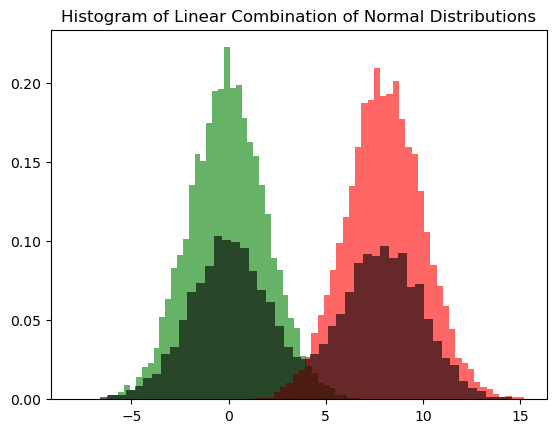

5059


In [60]:
np.random.seed(0)

mu1, sigma1 = 0, 2


n_samples = 10000
X1 = np.random.normal(mu1, sigma1, n_samples)

mu2, sigma2 = 8, 2


X2 = np.random.normal(mu2, sigma2, n_samples)

prob = np.random.choice([0, 1], size=10000)
# Draw samples
X3 = np.zeros(10000)
for i in range(10000):
    if prob[i] == 0:
        X3[i] = np.random.normal(mu1, sigma1)
    else:
        X3[i] = np.random.normal(mu2, sigma2)

plt.hist(X1, bins=50, density=True, alpha=0.6, color='g')
plt.hist(X2, bins=50, density=True, alpha=0.6, color='r')
plt.hist(X3, bins=50, density=True, alpha=0.6, color='black')
# plt.hist(X4, bins=50, density=True, alpha=0.6, color='purple')
plt.title('Histogram of Linear Combination of Normal Distributions')
plt.show()

number_of_zeros = np.count_nonzero(prob == 0)

print(number_of_zeros)  

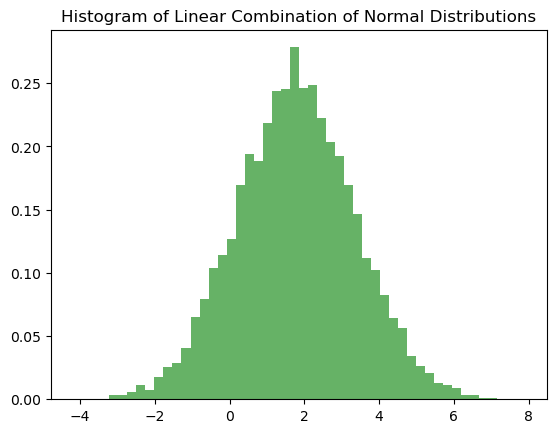

In [48]:
weights = [0.4, 0.6]
samples = [X1, X2]
X3 = np.sum([s * w for s,w in zip(samples, weights)], axis=0)
plt.hist(X3, bins=50, density=True, alpha=0.6, color='g')
plt.title('Histogram of Linear Combination of Normal Distributions')
plt.show()

In [32]:
mu1 = 0
sigma1 = 1
n_samples = 100

# Step 1: Generate samples
samples = np.random.normal(mu1, sigma1, n_samples)

# Step 2: Sort the samples
sorted_samples = np.sort(samples)

# Step 3: Calculate the CDF
cdf = np.arange(1, n_samples + 1) / n_samples

# # Step 4: Plot the CDF (optional)
# plt.plot(sorted_samples, cdf)
# plt.title('Cumulative Distribution Function (CDF)')
# plt.xlabel('Value')
# plt.ylabel('CDF')
# plt.grid(True)
# plt.show()
cdf

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

In [ ]:
np.random.seed(0)

# Parameters for the normal distributions
mu1, sigma1 = 0, 1


# Generate samples
n_samples = 100000
percentiles = [2.5, 97.5]
X1 = np.percentile(np.random.normal(mu1, sigma1, n_samples), percentiles)
print(np.percentile(np.random.normal(mu1, sigma1, n_samples), percentiles)[0])
# Plot the result
plt.hist(X1, bins=50, density=True, alpha=0.6, color='g')
plt.title('Histogram of Linear Combination of Normal Distributions')
plt.show()

In [ ]:
np.random.seed(0)

# Parameters for the normal distributions
mu2, sigma2 = 2, 1.5


# Generate samples
n_samples = 100000
X2 = np.random.normal(mu2, sigma2, n_samples)


# Plot the result
plt.hist(X2, bins=50, density=True, alpha=0.6, color='g')
plt.title('Histogram of Linear Combination of Normal Distributions')
plt.show()

In [ ]:
np.random.seed(0)

# Parameters for the normal distributions
mu1, sigma1 = 0, 1
mu2, sigma2 = 2, 1.5

# Weights
w1, w2 = 0.15, 0.85

# Generate samples
n_samples = 100000
X1 = np.random.normal(mu1, sigma1, n_samples)
X2 = np.random.normal(mu2, sigma2, n_samples)

# Linear combination
Z = w1*X1 + w2*X2

# Plot the result
plt.hist(Z, bins=50, density=True, alpha=0.6, color='g')
plt.title('Histogram of Linear Combination of Normal Distributions')
plt.show()

In [ ]:
mu = np.mean(Z)
var = np.var(Z, ddof=1) # ddof=1: to get an unbiased estimate
print(mu, var)

In [ ]:
a = pd.DataFrame({'a':[1,2,3], 'b':[4,5,6]})
for i, pred in enumerate(a['b']):
    print(i)

In [ ]:
a['b']

In [ ]:
array_2d = np.array([[1, 2], [3, 4], [5, 6]])

array_2d[1][0]

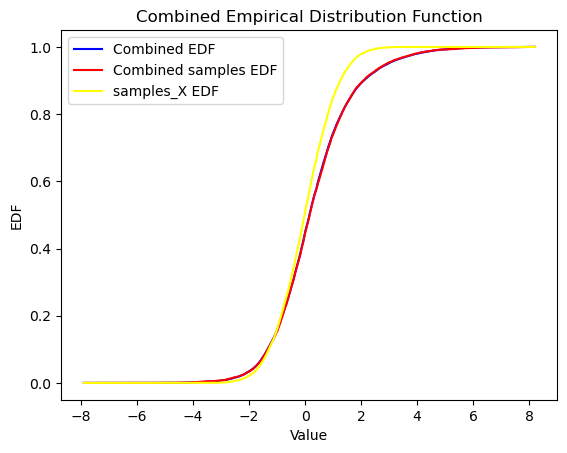

In [9]:
np.random.seed(0)
samples_X = np.random.normal(0, 1, 10000)
samples_Y = np.random.normal(1, 2, 10000) 

def edf(samples, x):
    return np.mean(samples <= x)

def combined_edf(x, samples_X, samples_Y, w_X, w_Y):
    return w_X * edf(samples_X, x) + w_Y * edf(samples_Y, x)

# Weights
w_X = 0.7
w_Y = 0.3

# Plotting the combined EDF
x_values = np.linspace(min(min(samples_X), min(samples_Y)), max(max(samples_X), max(samples_Y)), 1000)
combined_edf_values = [combined_edf(x, samples_X, samples_Y, w_X, w_Y) for x in x_values]

samples_X_values = [edf(samples_X, x) for x in x_values]


n_samples_X = int(10000 * w_X)  # Number of samples from this set
n_samples_Y = int(10000 * w_Y)
sampled_X = np.random.choice(samples_X, n_samples_X, replace=True)
sampled_Y = np.random.choice(samples_Y, n_samples_Y, replace=True)

combined_samples = np.concatenate([sampled_X, sampled_Y])

combined_samples_edf_values = [edf(combined_samples, x) for x in x_values]


plt.plot(x_values, combined_edf_values, label='Combined EDF', c='blue')
plt.plot(x_values, combined_samples_edf_values, label='Combined samples EDF', c='red')
plt.plot(x_values, samples_X_values, label='samples_X EDF', c='yellow')
plt.xlabel('Value')
plt.ylabel('EDF')
plt.title('Combined Empirical Distribution Function')
plt.legend()
plt.show()

In [81]:
np.random.seed(0)
mu1, sigma1 = 0, 1 
mu2, sigma2 = 1, 2  


n_samples = 100
prob_1 = 0.7
prob_2 = 0.3

samples_z = np.random.choice([1, 2], size=n_samples, p=[prob_1, prob_2])

count_1 = np.sum(samples_z == 1)
count_2 = np.sum(samples_z == 2)

print(samples_z)
combined_samples = np.zeros(n_samples)
for i in range(n_samples):
    if samples_z[i] == 1:
        combined_samples[i] = np.random.normal(mu1, sigma1)
    else:
        combined_samples[i] = np.random.normal(mu2, sigma2)
        
# print(combined_samples)
print(f'count of componet1 is {count_1}')
print(f'count of componet2 is {count_2}')
combined_samples

[1 2 1 1 1 1 1 2 2 1 2 1 1 2 1 1 1 2 2 2 2 2 1 2 1 1 1 2 1 1 1 2 1 1 1 1 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 2 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 2 1]
count of componet1 is 77
count of componet2 is 23


array([-1.16514984,  2.80165297,  0.46566244, -1.53624369,  1.48825219,
        1.89588918,  1.17877957,  0.64015033, -1.14150524,  1.05445173,
        0.19364611,  1.22244507,  0.20827498,  2.95327807,  0.3563664 ,
        0.70657317,  0.01050002,  4.57174099,  1.25382419,  1.80397873,
        4.76630139, -1.69551812, -1.270485  ,  2.93879342, -1.17312341,
        1.94362119, -0.41361898, -0.49490962,  1.92294203,  1.48051479,
        1.86755896,  2.81208932, -0.86122569,  1.91006495, -0.26800337,
        0.8024564 ,  0.94725197, -0.15501009,  2.22815874,  0.92220667,
        0.37642553, -1.09940079,  0.29823817,  1.3263859 , -0.69456786,
       -0.14963454, -0.43515355,  1.84926373,  0.67229476,  0.40746184,
       -0.76991607,  0.53924919, -0.34866532,  0.03183056, -0.63584608,
        0.67643329,  0.57659082, -0.20829876,  0.39600671, -1.09306151,
       -1.49125759,  0.4393917 ,  0.1666735 ,  0.63503144,  2.38314477,
        0.94447949, -0.82564445,  1.11701629, -1.63181482, -0.46

In [ ]:
### deleteme later
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
sb = pd.read_csv('Cardiovascular disease/pred_full/L8_S1.csv', parse_dates = [0], dayfirst = True)
sb['epiweek'] = sb['epiweek'].apply(create_epiweek_fromstr)
sb = sb.set_index('epiweek') 
sb

In [48]:
def smape(A, F):
    return 1/len(A) * np.sum(np.abs(F - A) / ((np.abs(A) + np.abs(F) + np.finfo(float).eps)/2))

In [49]:
model_list = list(sb.columns.values)
y = sb[['Cardiovascular disease']]
model_list.remove('Cardiovascular disease')

error_df = pd.DataFrame()
#print(model_list)

for model in model_list:
    model_val = sb[[model]].dropna()
    window_start = model_val.index[0]
    window_end = model_val.index[-1]
    y_val = y.loc[window_start:window_end].copy()
    error_df.at[model, 'MSE'] = mean_squared_error(y_val, model_val)
    error_df.at[model, 'MAPE'] = mean_absolute_percentage_error(y_val, model_val)
    error_df.at[model, 'MAE'] = mean_absolute_error(y_val, model_val)
    error_df.at[model, 'SMAPE'] = smape(np.array(y_val), np.array(model_val))

In [16]:
bbb = np.random.choice(['ww', 'wws', 'fd'], size=10)

In [17]:
print(bbb)

['ww' 'wws' 'fd' 'wws' 'ww' 'ww' 'fd' 'fd' 'fd' 'fd']


In [19]:
bbb[0]

'ww'

In [56]:
np.random.seed(0)

b = np.random.normal(8,2)
b

11.528104691935328

In [147]:
my_dict = {
    'name': 'John',
    'city': 'New York'
}
for item in my_dict.keys():
    my_dict[item] =  my_dict[item] + 'k'

In [148]:
my_dict

{'name': 'Johnk', 'city': 'New Yorkk'}

In [25]:
data_dict = {
    'data1': np.random.normal(loc=0, scale=1, size=1000),
    'data4': np.random.normal(loc=1, scale=1.5, size=1000),
    'data3': np.random.normal(loc=2, scale=0.5, size=1000)
}

In [30]:
first_item = list(data_dict.items())[0]
for i, j in first_item:
    print(i)
    print(j)

ValueError: too many values to unpack (expected 2)

In [22]:
a = np.array([1,2,3])+0.1
a

array([1.1, 2.1, 3.1])

In [25]:
np.zeros_like(a)

array([0., 0., 0.])

In [17]:
##
a = np.array([[1, 2, 3], 
                       [4, 5, 6], 
                       [7, 8, 9]])
a

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])